# Submission Information:

### Team Member 1:
* UNI:  WL2522
* Name:  Wilson Lui

### Team Member 2 [optional]:
* UNI:  
* Name:

# Step0 - Import Libraries, Load Data [0 points]

This is the basic step where you can load the data and create train and test sets for internal validation as per your convinience.

In [5]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, scale, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN




data = pd.read_csv('data\data.csv')

#Separate the ID column from the holdout set

holdout = pd.read_csv('data\holdout.csv')
ID = holdout['ID']
holdout = holdout.drop('ID', 1)

#Remove the "duration" feature to avoid getting overoptimistic results

data = data.drop('duration', 1)
holdout = holdout.drop('duration', 1)

#Separate the categorical features from the numerical ones
#Encode category and response variable strings to integers

num = ['age', 'campaign', 'prev_days', 'prev_contacts', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']

cat = ['job', 'marital_status', 'education', 'credit_default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'prev_outcomes']

enc_data = data.copy()
enc_holdout = holdout.copy()

le = LabelEncoder()

for col in cat:
    levels = enc_data[col].unique()
    le.fit(levels)
    enc_data[col] = le.transform(enc_data[col])
    enc_holdout[col] = le.transform(enc_holdout[col])

#Separate the features from the response variable

levels = enc_data['subscribed'].unique()
le.fit(levels)
enc_data['subscribed'] = le.transform(enc_data['subscribed'])

X = enc_data.iloc[:,:-1]
y = enc_data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)


['nonexistent' 'failure' 'success']


# Step1 - Exploration and Preparation [10 points]

In this step, we expect you to look into the data and try to understand it before modeling. This understanding may lead to some basic data preparation steps which are common across the two model sets required.

In [62]:
#Get summary statistics on the data

data.describe()

,age,campaign,prev_days,prev_contacts,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
count,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000
mean,40.019059,2.641639,961.537906,0.174385,0.080115,93.583705,-40.496740,3.618901,5166.932832
std,10.850807,2.803230,189.209917,0.498989,1.573180,1.162662,4.645301,1.737149,72.439480
min,17.000000,1.000000,0.000000,0.000000,-3.695294,88.311974,-52.220779,0.325461,4963.600000
25%,32.000000,1.000000,999.000000,0.000000,-1.724208,92.800661,-43.087110,1.377065,5101.000000
50%,38.000000,2.000000,999.000000,0.000000,1.085053,93.586959,-41.685507,4.800570,5194.000000
75%,47.000000,3.000000,999.000000,0.000000,1.366367,94.381404,-36.404580,4.943674,5226.000000
max,97.000000,56.000000,999.000000,7.000000,1.785673,98.263042,-25.323735,5.362403,5249.000000


Counter({'admin.': 8342, 'blue-collar': 7408, 'technician': 5371, 'services': 3168, 'management': 2340, 'retired': 1390, 'entrepreneur': 1198, 'self-employed': 1140, 'housemaid': 827, 'unemployed': 797, 'student': 708, 'unknown': 261})


([<matplotlib.axis.XTick at 0x265691f5400>,
 <a list of 12 Text xticklabel objects>)

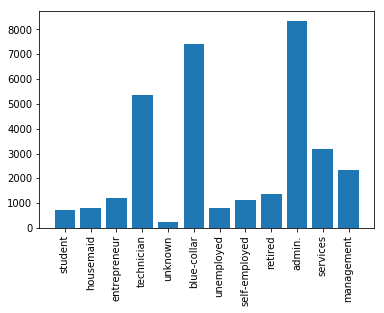

In [3]:
#Examine the distribution of job categories

job_count = Counter(data['job'])
print(job_count)
plt.bar(range(len(job_count)), job_count.values(), align='center')
plt.xticks(range(len(job_count)), list(job_count.keys()), rotation='vertical')


Counter({'married': 19955, 'single': 9256, 'divorced': 3676, 'unknown': 63})


([<matplotlib.axis.XTick at 0x26569153080>,
 <a list of 4 Text xticklabel objects>)

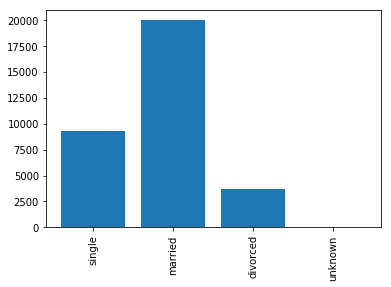

In [4]:
#Examine the distribution of marital statuses

marital_count = Counter(data['marital_status'])
print(marital_count)
plt.bar(range(len(marital_count)), marital_count.values(), align='center')
plt.xticks(range(len(marital_count)), list(marital_count.keys()), rotation='vertical')


Counter({'university.degree': 9760, 'high.school': 7580, 'basic.9y': 4889, 'professional.course': 4154, 'basic.4y': 3313, 'basic.6y': 1846, 'unknown': 1394, 'illiterate': 14})


([<matplotlib.axis.XTick at 0x2656919ba58>,
 <a list of 8 Text xticklabel objects>)

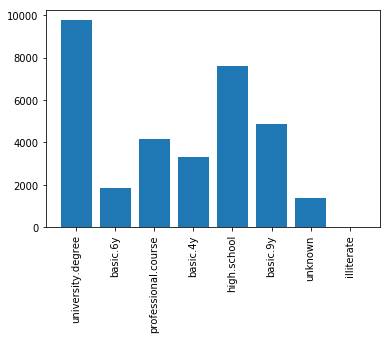

In [5]:
#Examine the distribution of education levels

education_count = Counter(data['education'])
print(education_count)
plt.bar(range(len(education_count)), education_count.values(), align='center')

plt.xticks(range(len(education_count)), list(education_count.keys()), rotation='vertical')

Counter({'no': 26059, 'unknown': 6888, 'yes': 3})
Counter({'yes': 17176, 'no': 14974, 'unknown': 800})
Counter({'no': 27179, 'yes': 4971, 'unknown': 800})
Counter({'cellular': 20902, 'telephone': 12048})


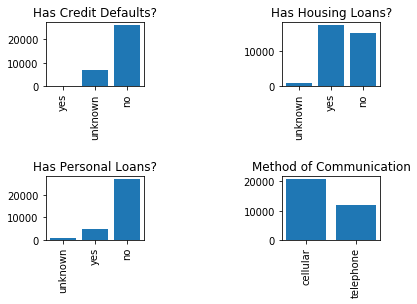

In [6]:
#Examine distribution of binary variables

default_count = Counter(data['credit_default'])
housing_count = Counter(data['housing'])
loan_count = Counter(data['loan'])
contact_count = Counter(data['contact'])
print(default_count)
print(housing_count)
print(loan_count)
print(contact_count)


ax1 = plt.subplot('331')
plt.bar(range(len(default_count)), default_count.values(), align='center')
plt.xticks(range(len(default_count)), list(default_count.keys()), rotation='vertical')
ax1.set_title('Has Credit Defaults?')

ax2 = plt.subplot('333')
plt.bar(range(len(housing_count)), housing_count.values(), align='center')
plt.xticks(range(len(housing_count)), list(housing_count.keys()), rotation='vertical')
ax2.set_title('Has Housing Loans?')

ax3 = plt.subplot('337')
plt.bar(range(len(loan_count)), loan_count.values(), align='center')
plt.xticks(range(len(loan_count)), list(loan_count.keys()), rotation='vertical')
ax3.set_title('Has Personal Loans?')

ax4 = plt.subplot('339')
plt.bar(range(len(contact_count)), contact_count.values(), align='center')
plt.xticks(range(len(contact_count)), list(contact_count), rotation='vertical')
ax4.set_title('Method of Communication')

([<matplotlib.axis.YTick at 0x2cea1d86630>,
 <a list of 19 Text yticklabel objects>)

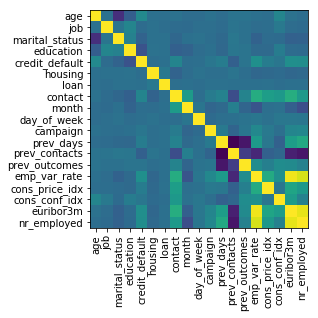

In [55]:
#Create covariance matrix heatmap to check for correlated features

cov = np.cov(scale(X_train), rowvar = False)
plt.imshow(cov, cmap='viridis', interpolation='nearest')
plt.xticks(range(len(list(X_train))), list(X_train), rotation = 'vertical')
plt.yticks(range(len(list(X_train))), list(X_train))

In [14]:
from sklearn.feature_selection import mutual_info_classif
score = mutual_info_classif(X_train, y_train, discrete_features = [1,2,3,4,5,6,7,8,9,13])

from sklearn.feature_selection import f_classif
f_score = f_classif(X_train, y_train)
mi_score = mutual_info_classif(X_train, y_train)
print(mi_score)
print(f_score)

[ 0.00691953  0.01288572  0.00693719  0.00289419  0.01001758  0.00133675
  0.00312493  0.01176952  0.02795122  0.00140462  0.00024864  0.03438093
  0.01959197  0.03077206  0.04814837  0.          0.05242143  0.05630778
  0.0641352 ]
(array([  1.04857099e+01,   2.08001473e+01,   6.14920477e+01,
         9.50088876e+01,   2.46146619e+02,   1.26006064e+01,
         5.02433811e-01,   5.22542694e+02,   2.75606480e-01,
         4.88612992e+00,   1.18084991e+02,   2.94373920e+03,
         1.37564973e+03,   4.90872737e+02,   2.44640280e+03,
         1.49917538e+02,   6.86169604e+01,   2.63317569e+03,
         3.59645237e+03]), array([  1.20460123e-003,   5.12237283e-006,   4.62411693e-015,
         2.08005058e-022,   3.32008751e-055,   3.86337496e-004,
         4.78439362e-001,   1.82389233e-114,   5.99600163e-001,
         2.70824354e-002,   1.91652859e-027,   0.00000000e+000,
         4.40972767e-293,   1.03063842e-107,   0.00000000e+000,
         2.27326457e-034,   1.25566790e-016,   0.0000

# Step2 - ModelSet1 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set1:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. Any classification algorithm covered in class apart from tree-based models can be tested here.

In [12]:
#Perform One Hot Encoding on the training set

discrete = [1,2,3,4,5,6,7,8,9,13]

X_train_OHE = X_train.as_matrix()

def OHE(X, discrete_features):

    OHE = OneHotEncoder().fit(X[:, [discrete_features]].reshape(-1,1))
    enc_discrete = OHE.transform(X[:,1].reshape(-1,1)).toarray()

    for col in discrete_features[1:]:
        enc = OneHotEncoder().fit_transform(X[:, col].reshape(-1,1)).toarray()
        enc_discrete = np.append(enc_discrete, enc, axis = 1)

    X = np.delete(X, discrete_features, axis=1)
    X = np.append(X, enc_discrete, axis = 1)
    
    return X

#correlated = [8,7]
#X_train_OHE = np.delete(X_train_OHE, correlated, axis = 1)


In [24]:
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC

sm = SMOTEENN()
X_smote, y_smote = sm.fit_sample(X_train_OHE, y_train)

svc = LinearSVC()
svc_rfe = RFE(svc, n_features_to_select = 15)
svc_rfe.fit(X_smote, y_smote)
print(rfe.ranking_)


[4 1 1 1 1 2 1 1 1 1 1 5 1 1 1 1 1 1 3]


In [25]:
lr = LogisticRegression()
lr_rfe = RFE(lr, n_features_to_select = 15)
lr_rfe.fit(X_smote, y_smote)
print(lr_rfe.ranking_)

[2 4 1 1 1 1 1 1 1 1 1 5 1 1 1 1 1 1 3]


In [21]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif

f = SelectKBest(f_classif, k=15)
mi = SelectKBest(mutual_info_classif, k=15)
                
f.fit(X_smote, y_smote)
mi.fit(X_smote, y_smote)

print('f', f.get_support())
print('mi', mi.get_support())

f [False  True  True  True  True  True False  True False False  True  True
  True  True  True  True  True  True  True]
mi [ True  True  True  True False  True False  True  True  True  True False
  True  True  True False  True  True  True]


In [6]:


param_grid = {'C': np.logspace(-3, 2, 6),
              'gamma': np.logspace(-3, 2, 6) / np.shape(X_train_OHE)[0]}

sm = SMOTEENN()
X_smote, y_smote = sm.fit_sample(X_train_OHE, y_train)

#roc = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
#roc.fit(X_train_OHE, y_train)
#print(grid.best_params_)
#print(grid_score(X_smote, y_smote, scoring='roc_auc'))

In [16]:
pipe.predict_proba(X_smote)


array([[ 0.77113489,  0.22886511],
       [ 0.75166589,  0.24833411],
       [ 0.76911286,  0.23088714],
       ..., 
       [ 0.23408144,  0.76591856],
       [ 0.76048712,  0.23951288],
       [ 0.76567808,  0.23432192]])

In [ ]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline as imb_pipeline


#rus = RandomUnderSampler(replacement=True)
sm = SMOTEENN()
X_smote, y_smote = sm.fit_sample(X_train_OHE, y_train)
print(X_smote.shape)
pipe = make_pipeline(LogisticRegression(C = 0.5, penalty='l1'))
score = cross_val_score(pipe, X_smote, y_smote, cv=5, scoring = 'roc_auc')
print(score)



# Step3 - ModelSet2 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set2:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. We encourage you to try decition tree, random forest and gradient boosted tree methods here and pick the one which you think works best.

In [4]:
#write code below, you can make multiple cells

# Step4 - Ensemble [20 points + 10 Bonus points]

In this step, we expect you to use the models created before and create new predictions. You should definitely try poor man's stacking but we encourage you to think of different ensemble techniques as well. We will judge your creativity and improvement in model performance using ensemble models and you can potentially earn 10 bonus points here.

In [5]:
#write code below, you can make multiple cells
assert True